In [1]:
import pandas as pd
import zipfile


zf = zipfile.ZipFile('./berlin-airbnb-data.zip')

file_names = zf.namelist()


calendar_summary = pd.read_csv(zf.open(file_names[0]))

listings = pd.read_csv(zf.open(file_names[1]))

listings_summary = pd.read_csv(zf.open(file_names[2]))

neighbourhoods = pd.read_csv(zf.open(file_names[3]))

reviews = pd.read_csv(zf.open(file_names[4]))

reviews_summary = pd.read_csv(zf.open(file_names[5]))

In [2]:
listings_summary.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,t,NaN,NaN,f,f,flexible,f,f,1,1.42
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-11-07,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,...,t,NaN,NaN,t,f,strict_14_with_grace_period,f,f,1,1.25
3,3309,https://www.airbnb.com/rooms/3309,20181107122246,2018-11-07,BerlinSpot Schöneberg near KaDeWe,First of all: I prefer short-notice bookings. ...,"Your room is really big and has 26 sqm, is ver...",First of all: I prefer short-notice bookings. ...,none,"My flat is in the middle of West-Berlin, direc...",...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.39
4,7071,https://www.airbnb.com/rooms/7071,20181107122246,2018-11-07,BrightRoom with sunny greenview!,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft²), ...",Cozy and large room in the beautiful district ...,none,"Great neighborhood with plenty of Cafés, Baker...",...,t,NaN,NaN,f,f,moderate,f,f,1,1.75


In [3]:
# These are the columns I will keep for regression at this time.

columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df = listings_summary[columns_to_keep].set_index('id')
df.shape

(22552, 23)

In [4]:
# Extracted square meters from the description by getting 2 to 3 digits that where together folowwed by sm/SM

df['size'] = df['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df['size'] = df['size'].str.replace("\D", "")

# change datatype of size into float
df['size'] = df['size'].astype(float)

In [5]:
print('The following number is the amount of null values in our dataframe after we extract sqm')
print(df['size'].isnull().sum())
df[['size', 'description']]

The following number is the amount of null values in our dataframe after we extract sqm
11794


,size,description
id,,
2015,75.0,Great location! 30 of 75 sq meters. This wood...
2695,25.0,In the summertime we are spending most of our ...
3176,68.0,This beautiful first floor apartment is situa...
3309,26.0,First of all: I prefer short-notice bookings. ...
7071,20.0,Cozy and large room in the beautiful district ...
...,...,...
29856708,NaN,Charming apartment right in the center of Berl...
29857108,NaN,Die Wohnung liegt in unmittelbarer Nähe zum Vi...
29864272,NaN,Prenzlauer Berg is one of the most creative di...


In [6]:
# Here I will separate descirption from the dataframe to specifically remove stop words and lemmatize
bag_of_words = df['description'].copy()

In [7]:
bag_of_words.head()

id
2015    Great location!  30 of 75 sq meters. This wood...
2695    In the summertime we are spending most of our ...
3176    This beautiful first floor apartment  is situa...
3309    First of all: I prefer short-notice bookings. ...
7071    Cozy and large room in the beautiful district ...
Name: description, dtype: object

In [21]:
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [24]:
df['description'] = df.description.fillna('emptydescription')

tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(df['description'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens'] = tokens



In [26]:
from collections import Counter
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [27]:
wc = count(df['tokens'])
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
1622,und,6637,26273,1.0,0.015252,0.015252,0.294298
64,,11069,24453,2.0,0.014196,0.029448,0.490821
10,room,9590,17174,3.0,0.009970,0.039418,0.425239
38,apartment,8766,16896,4.0,0.009809,0.049227,0.388702
2866,die,5245,14372,5.0,0.008343,0.057570,0.232574
1183,der,5298,12850,6.0,0.007460,0.065030,0.234924
2095,mit,5070,12319,7.0,0.007152,0.072181,0.224814
1585,ist,5152,11819,8.0,0.006861,0.079043,0.228450
3,berlin,7175,9968,9.0,0.005787,0.084829,0.318154
18,kitchen,7322,9283,10.0,0.005389,0.090218,0.324672


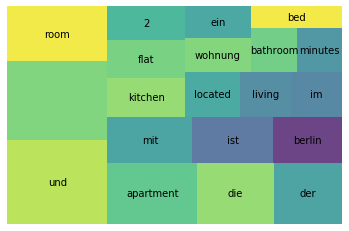

In [30]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

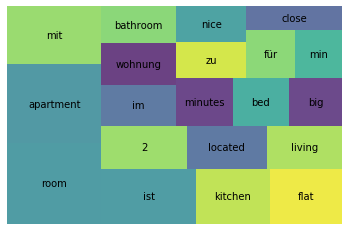

In [38]:
# I add 'und' to the stop words since after translation I can conclude it is no useful
# I also remove the word 'die' since it is translated to 'the' in english

STOP_WORDS = nlp.Defaults.stop_words.union([' ', 'und', '-', 'die', 'der', 'berlin', 'ein', 'das'])

tokens = []

for doc in tokenizer.pipe(df['description'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['tokens'] = tokens

wc = count(df['tokens'])
wc.head(30)

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [39]:
df['tokens']

id
2015        [great, location!, 30, 75, sq, meters., wood, ...
2695        [summertime, spending, weekends, little, house...
3176        [beautiful, floor, apartment, situated, kollwi...
3309        [all:, prefer, short-notice, bookings., reques...
7071        [cozy, large, room, beautiful, district, prenz...
                                  ...                        
29856708    [charming, apartment, right, center, berlin,, ...
29857108    [wohnung, liegt, unmittelbarer, nähe, zum, vik...
29864272    [prenzlauer, berg, creative, districts, plenty...
29866805    [double, rooms, private, shower, /, wc, design...
29867352    [sunny,, modern, cozy, 3-bedroom, shared, flat...
Name: tokens, Length: 22552, dtype: object

In [40]:
wc.shape

(105310, 7)

In [42]:
description_summary = []
for set_of_lemmas in df['tokens'].values:
    working_set = ""
    for lemma in set_of_lemmas:
        working_set += lemma + ' '
    description_summary.append(working_set)

In [49]:
description_summary[0:2]

['great location! 30 75 sq meters. wood floored/high ceiling typical "altbau" section apartment consists 1 simple large room, small kitchen bathroom + shower. apartment mitte, close prenzlauer berg/mauerpark. perfect short visits, singles couples. section closed rest bigger flat wich noticeable. sharing space. a+++ location! „einliegerwohnung“ extention larger apartment separate entrance, bathroom kitchen. door rest apartment soundproof, hidden, locked barely noticable (behind mirror pictures). 30 sq meters facing quiet courtyard. wood floored/high ceiling typical "altbau" apartment consists 1 large room large double bed, optionally extra matress 3rd guest), small kitchen suitable preparing simple meals, bathroom + shower + bathtub course entrance (all linens ',
 "summertime spending weekends little house garden want use opportunity rent room cosy 2 bedroom apartment. stay room. happy tips things sure stay runs smoothly. room 25 square meters located 2nd floor. bed measures 180 cm x 20

In [54]:
type(description_summary)

list

In [59]:
df['ready_lemma']=description_summary

In [63]:
df.ready_lemma.iloc[0]

'great location! 30 75 sq meters. wood floored/high ceiling typical "altbau" section apartment consists 1 simple large room, small kitchen bathroom + shower. apartment mitte, close prenzlauer berg/mauerpark. perfect short visits, singles couples. section closed rest bigger flat wich noticeable. sharing space. a+++ location! „einliegerwohnung“ extention larger apartment separate entrance, bathroom kitchen. door rest apartment soundproof, hidden, locked barely noticable (behind mirror pictures). 30 sq meters facing quiet courtyard. wood floored/high ceiling typical "altbau" apartment consists 1 large room large double bed, optionally extra matress 3rd guest), small kitchen suitable preparing simple meals, bathroom + shower + bathtub course entrance (all linens '

In [65]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        #if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
        lemmas.append(token.lemma_)
    
    return lemmas

In [66]:
df['lemma'] = df['ready_lemma'].apply(get_lemmas)

In [67]:
df['lemma']

id
2015        [great, location, !, 30, 75, sq, meter, ., woo...
2695        [summertime, spending, weekend, little, house,...
3176        [beautiful, floor, apartment, situate, kollwit...
3309        [all, :, prefer, short, -, notice, booking, .,...
7071        [cozy, large, room, beautiful, district, prenz...
                                  ...                        
29856708    [charming, apartment, right, center, berlin, ,...
29857108    [wohnung, liegt, unmittelbarer, nähe, zum, vik...
29864272    [prenzlauer, berg, creative, district, plenty,...
29866805    [double, room, private, shower, /, wc, design,...
29867352    [sunny, ,, modern, cozy, 3-bedroom, share, fla...
Name: lemma, Length: 22552, dtype: object

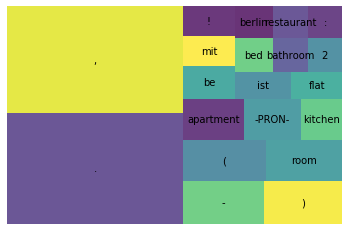

In [69]:
wc = count(df['lemma'])
wc.head(30)

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [70]:
lemma_summary = []
for set_of_lemmas in df['lemma'].values:
    working_set = ""
    for lemma in set_of_lemmas:
        working_set += lemma + ' '
    lemma_summary.append(working_set)

df['lemma_not_finished']=lemma_summary

In [71]:
df['lemma_not_finished']

id
2015        great location! 30 75 sq meters. wood floored/...
2695        summertime spending weekends little house gard...
3176        beautiful floor apartment situated kollwitzpla...
3309        all: prefer short-notice bookings. requests 1-...
7071        cozy large room beautiful district prenzlauer ...
                                  ...                        
29856708    charming apartment right center berlin, close ...
29857108    wohnung liegt unmittelbarer nähe zum viktoria ...
29864272    prenzlauer berg creative districts plenty bars...
29866805    double rooms private shower / wc designed arti...
29867352    sunny, modern cozy 3-bedroom shared flat heart...
Name: lemma_not_finished, Length: 22552, dtype: object

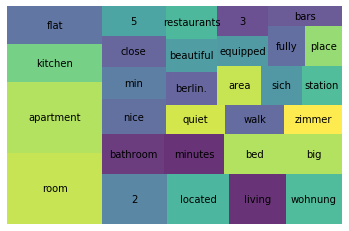

In [87]:
STOP_WORDS = nlp.Defaults.stop_words.union([' ', 'und', '-', 'die', 'der', 'berlin', 'ein', 'das', 'mit', 'ist', 'im', 'zu', 'eine', 'es', 'für'
                                            'berlin.', 'zum', 'sind', 'für', 'Berlin.'])

tokens = []

for doc in tokenizer.pipe(df['lemma_not_finished'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            if token.text.lower() not in STOP_WORDS:
                doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['lemma'] = tokens

wc = count(df['lemma'])
wc.head(30)

wc_top20 = wc[wc['rank'] <= 30]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [88]:
wc.shape

(105025, 7)

In [90]:
wc.head(50)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
9,room,9590,17174,1.0,0.010991,0.010991,0.425239
37,apartment,8766,16896,2.0,0.010813,0.021804,0.388702
17,kitchen,7322,9283,3.0,0.005941,0.027744,0.324672
53,flat,5500,9052,4.0,0.005793,0.033537,0.243881
90,2,5735,8165,5.0,0.005225,0.038763,0.254301
127,located,6083,7697,6.0,0.004926,0.043689,0.269732
190,living,5141,7166,7.0,0.004586,0.048275,0.227962
2871,wohnung,4017,6999,8.0,0.004479,0.052754,0.178122
51,bathroom,5298,6241,9.0,0.003994,0.056748,0.234924
577,minutes,3983,6174,10.0,0.003951,0.060699,0.176614


In [91]:
df.lemma

id
2015        [great, location!, 30, 75, sq, meters., wood, ...
2695        [summertime, spending, weekends, little, house...
3176        [beautiful, floor, apartment, situated, kollwi...
3309        [all:, prefer, short-notice, bookings., reques...
7071        [cozy, large, room, beautiful, district, prenz...
                                  ...                        
29856708    [charming, apartment, right, center, berlin,, ...
29857108    [wohnung, liegt, unmittelbarer, nähe, viktoria...
29864272    [prenzlauer, berg, creative, districts, plenty...
29866805    [double, rooms, private, shower, wc, designed,...
29867352    [sunny,, modern, cozy, 3-bedroom, shared, flat...
Name: lemma, Length: 22552, dtype: object

In [95]:
lemma = df[['lemma']].copy()
lemma.head()

,lemma
id,
2015,"[great, location!, 30, 75, sq, meters., wood, ..."
2695,"[summertime, spending, weekends, little, house..."
3176,"[beautiful, floor, apartment, situated, kollwi..."
3309,"[all:, prefer, short-notice, bookings., reques..."
7071,"[cozy, large, room, beautiful, district, prenz..."


In [141]:
from gensim import corpora
id2word = corpora.Dictionary(lemma.lemma)
len(id2word.keys())

105025

In [142]:
id2word.filter_extremes(no_below=500)
len(id2word.keys())

466

In [143]:
corpus = [id2word.doc2bow(text) for text in lemma.lemma]

In [144]:
id2word.token2id['room']

22

In [145]:
type(lemma)

pandas.core.frame.DataFrame

In [151]:
df['lemma'] = df['ready_lemma'].apply(get_lemmas)

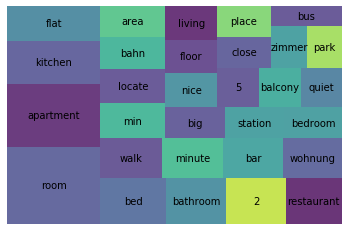

In [166]:
STOP_WORDS = nlp.Defaults.stop_words.union([' ', 'und', '-', 'die', 'der', 'berlin', 'ein', 'das', 'mit', 'ist', 'im', 'zu', 'eine', 'es', 'für'
                                            'berlin.', 'zum', 'sind', 'für', 'Berlin.', '-pron-', 's', 'u'])

tokens = []

for doc in tokenizer.pipe(df['bag_of_words'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            if token.text.lower() not in STOP_WORDS:
                doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['lemma'] = tokens

wc = count(df['lemma'])
wc.head(30)

wc_top20 = wc[wc['rank'] <= 30]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [167]:
lemma_summary = []
for set_of_lemmas in df['lemma'].values:
    working_set = ""
    for lemma in set_of_lemmas:
        working_set += lemma + ' '
    lemma_summary.append(working_set)

df['bag_of_words']=lemma_summary

In [168]:
lemma = df[['bag_of_words']].copy()
lemma.head()

,bag_of_words
id,
2015,great location 30 75 sq meter wood floor high ...
2695,summertime spending weekend little house garde...
3176,beautiful floor apartment situate kollwitzplat...
3309,prefer short notice booking request 1 2 week a...
7071,cozy large room beautiful district prenzlauer ...


In [169]:
lemma.to_csv('lemma.csv', index=True)

In [170]:
test_lemma = pd.read_csv('./lemma.csv')

In [172]:
test_lemma.head()

,id,bag_of_words
0,2015,great location 30 75 sq meter wood floor high ...
1,2695,summertime spending weekend little house garde...
2,3176,beautiful floor apartment situate kollwitzplat...
3,3309,prefer short notice booking request 1 2 week a...
4,7071,cozy large room beautiful district prenzlauer ...


In [173]:
test_lemma.bag_of_words

0        great location 30 75 sq meter wood floor high ...
1        summertime spending weekend little house garde...
2        beautiful floor apartment situate kollwitzplat...
3        prefer short notice booking request 1 2 week a...
4        cozy large room beautiful district prenzlauer ...
                               ...                        
22547    charming apartment right center close main tou...
22548    wohnung liegt unmittelbarer nähe viktoria luis...
22549    prenzlauer berg creative district plenty bar r...
22550    double room private shower wc design artist ro...
22551    sunny modern cozy 3-bedroom share flat heart v...
Name: bag_of_words, Length: 22552, dtype: object

In [175]:
lemma.bag_of_words

id
2015        great location 30 75 sq meter wood floor high ...
2695        summertime spending weekend little house garde...
3176        beautiful floor apartment situate kollwitzplat...
3309        prefer short notice booking request 1 2 week a...
7071        cozy large room beautiful district prenzlauer ...
                                  ...                        
29856708    charming apartment right center close main tou...
29857108    wohnung liegt unmittelbarer nähe viktoria luis...
29864272    prenzlauer berg creative district plenty bar r...
29866805    double room private shower wc design artist ro...
29867352    sunny modern cozy 3-bedroom share flat heart v...
Name: bag_of_words, Length: 22552, dtype: object

In [177]:
wc.shape

(52387, 7)